In [192]:
# Plotting and data manipulation libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Model selection and evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Dimensionality reduction libraries
from sklearn.decomposition import PCA as SklearnPCA
from scipy.linalg import null_space
from sklearn.decomposition import PCA


# Model libraries
from sklearn.ensemble import RandomForestClassifier


# SHAP libraries
import shap


Dataset: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

# Exploratory Data Analysis

##### Reading in the data

In [193]:
df = pd.read_csv("data/bar_pass_prediction.csv")
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the unprocessed dataset")
df.head()


There are 22407 rows and 39 columns in the unprocessed dataset


,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


There seems to be many columns in this dataset which are either useless or copies/transformations of other columns.
This notebook will therefore focus heavily on processing the data.

#### Columns I decided to drop

The variable names are not straightforward but a Kaggle user had described some of them here: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage/discussion/350765 which I will be using as a loose guide along with my own analysis


Based on the initial description, these are the columns I will be dropping:

- dnn_bar_pass_prediction (Models prediction of whether or not the student will pass)
- Cluster -> was unable to find a description and I had no idea what this represented when I looked at the data
- index6040, indxgrp and indexgrp2 -> Again it was very unclear what these columns represented
- gpa, zgpa, zfygpa - These values are completely correlated with UGPA which corresponds to a students undergraduate GPA so there was no point in keeping them
- bar1, bar1_yr, bar2, bar2_yr, bar_passed -> Again, these columns just gives us (a bit more nuanced) information about whether a student passed or not.
- race, race2, asian, black, hisp -> We can just use the race1. All other variation were more lacking in the sense that there are missing values
- Dropout -> This is just a column consisting of zeroes
- parttime -> There is another column named "full-time" which correlated perfectly with parttime so I decided to drop parttime
- age  -> There are many negativie values present which doesn't make sense for age (this is confirmed in the code below)
- male, sex -> this information is already in the gender column



In [194]:

columns_to_drop = [
    'dnn_bar_pass_prediction',
    'cluster',
    'index6040', 'indxgrp', 'indxgrp2',
    'gpa', 'zgpa', 'zfygpa',
    'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'bar_passed',
    'race', 'race2', 'asian', 'black', 'hisp',
    'Dropout',
    'parttime',
    'age',
    'male', 'sex', 'other',
    'ID'
]

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')



#### Columns I decided to keep

The remaining columns that are left can be described as follow:

- decile1, decile1b, decile3 -> Describes the law school ranking by decile of each candidate in year 1 (semester 1, semester 2) and year 3. I'm not sure why the remaining years are not included though.
- lsat -> The LSAT score of each candidate (although it has been altered somehow as it's not within the normal range, but it still correlated with the target (passed/not passed) as seen in the code below so therefore I decided to keep it)
- grad - This is a binary column describing whether a student graduated or not
- fulltime -> If the student a full-time student.
- fam_inc -> Family income by quintile.
- tier -> What tier law school did the student attend by quintile.
- race1 -> The race of the student.
- sex -> the gender of the student.
- pass_bar -> This is the target variable. Did the student pass the bar.









So after these adjustments, the dataframe looks as follows:







In [195]:
df.head()

,decile1b,decile3,decile1,lsat,ugpa,DOB_yr,grad,fulltime,fam_inc,gender,race1,pass_bar,bar,tier
0,10.0,10.0,10.0,44.0,3.5,69.0,Y,1.0,5.0,female,white,1,a Passed 1st time,4.0
1,5.0,4.0,5.0,29.0,3.5,69.0,Y,1.0,4.0,female,white,1,a Passed 1st time,2.0
2,3.0,2.0,3.0,36.0,3.5,65.0,Y,1.0,1.0,male,white,1,a Passed 1st time,3.0
3,7.0,4.0,7.0,39.0,3.5,58.0,Y,1.0,4.0,male,white,1,a Passed 1st time,3.0
4,9.0,8.0,9.0,48.0,3.5,68.0,Y,1.0,4.0,male,white,1,a Passed 1st time,5.0


#### Missing values

In [196]:
# Checking for null values across all columns
df.isnull().sum()


decile1b    1604
decile3     1604
decile1     1092
lsat           0
ugpa           0
DOB_yr        50
grad           3
fulltime      34
fam_inc      289
gender         5
race1         16
pass_bar       0
bar            0
tier          96
dtype: int64

There seems to be quite a few missing values across many columns. I will deal with those in the cell below by replace NaN with mean for numeric columns, and mode for categorical columns

In [197]:

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Display identified columns
print("Numeric columns:")
print(numeric_cols)
print("\nCategorical columns:")
print(categorical_cols)

# Fill missing values based on data type and context
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify that all missing values are filled
missing_counts_after = df.isnull().sum()
print("\nMissing Value Counts after filling:")
print(missing_counts_after)

Numeric columns:
['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'DOB_yr', 'fulltime', 'fam_inc', 'pass_bar', 'tier']

Categorical columns:
['grad', 'gender', 'race1', 'bar']

Missing Value Counts after filling:
decile1b    0
decile3     0
decile1     0
lsat        0
ugpa        0
DOB_yr      0
grad        0
fulltime    0
fam_inc     0
gender      0
race1       0
pass_bar    0
bar         0
tier        0
dtype: int64


/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/881465487.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/881465487.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

## Visualisations to help understand the data

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/2318559575.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pass_bar', palette='pastel')


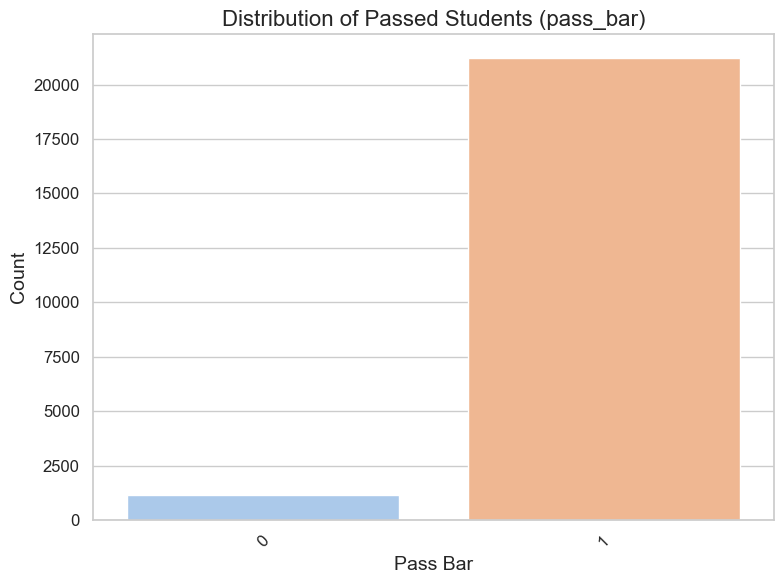

In [198]:

# Set the overall style for the plots
sns.set(style="whitegrid")


# Plotting the overall distribution of the target column 'pass_bar'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='pass_bar', palette='pastel')
plt.title('Distribution of Passed Students (pass_bar)', fontsize=16)
plt.xlabel('Pass Bar', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [199]:
percent_pass = df['pass_bar'].value_counts(normalize=True) * 100
percent_pass

pass_bar
1    94.78288
0     5.21712
Name: proportion, dtype: float64

From this we see that there is a quite uneven class distribution

#### EDA into the protected features: Race and Sex

Counting the distribution of different genders and races

df['gender'].value_counts()


In [200]:
df['race1'].value_counts()


race1
white    18732
black     1343
hisp      1027
asian      897
other      408
Name: count, dtype: int64

We see that there are more men by about 12 percent and the amount of white students are generally about 80 percent more in comparison to each other individual race

Now let's visualise the pass rate in relation to sex and race:

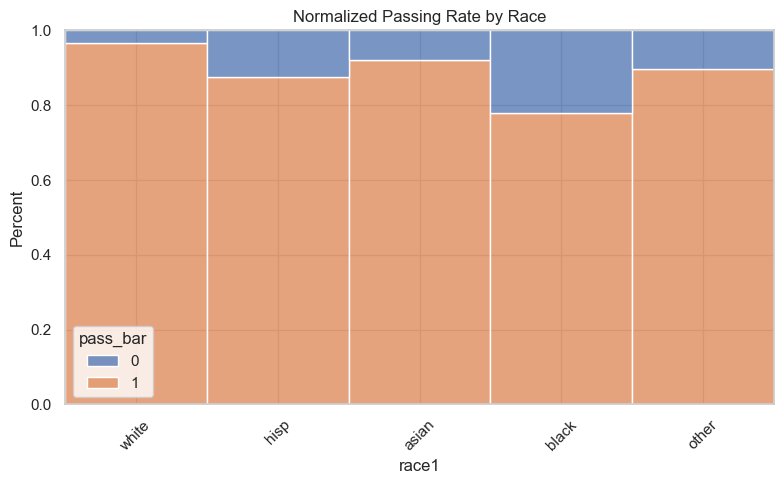

In [201]:


plt.figure(figsize=(8, 5))

# Plot normalized histogram
sns.histplot(data=df, x='race1', hue='pass_bar', multiple="fill", kde=False, stat="percent")
plt.title('Normalized Passing Rate by Race')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig("plots/passing_rate_race.png")

# Show the plot
plt.show()




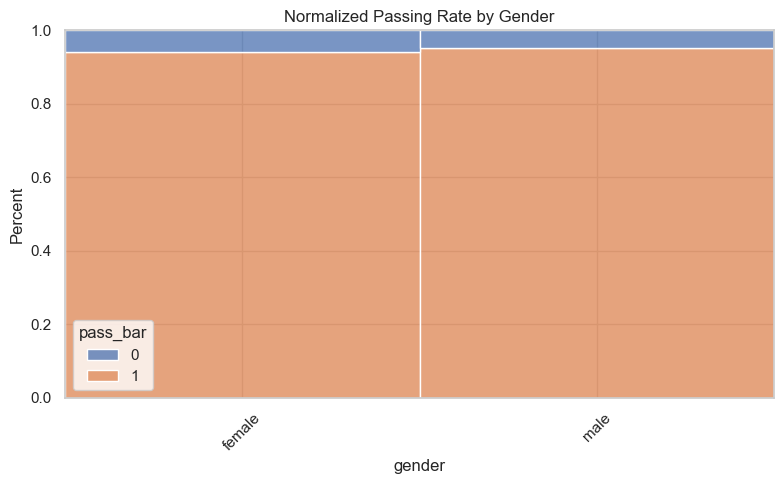

In [202]:


plt.figure(figsize=(8, 5))

# Plot normalized histogram
sns.histplot(data=df, x='gender', hue='pass_bar', multiple="fill", kde=False, stat="percent")
plt.title('Normalized Passing Rate by Gender')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig("plots/passing_rate_gender.png")

# Show the plot
plt.show()




### One hot encoding and replacing text values with numerical

In [203]:


def preprocess_data(df, numeric_cols, binary_cols, categorical_cols, target_col, scale_numeric=True):
    # Define transformers for numeric, categorical, and binary columns
    if scale_numeric:
        numeric_transformer = StandardScaler()
    else:
        # Non-scaled version: Include binary transformer to map 'grad' and 'gender'
        numeric_transformer = 'passthrough'
        binary_transformer = 'passthrough'
        df['gender'] = df['gender'].map({'male': 1, 'female': 0})
        df['grad'] = df['grad'].map({'Y': 1, 'X': 0, 'O': 0})

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Combine transformers using ColumnTransformer
    if scale_numeric:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols),
                ('bin', 'passthrough', binary_cols)  # Pass binary columns through without scaling
            ],
            remainder='drop'  # Drop any columns not explicitly transformed
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols),
                ('bin', binary_transformer, binary_cols)  # Map binary columns to numeric values
            ],
            remainder='drop'  # Drop any columns not explicitly transformed
        )

    # Create the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    X_preprocessed = pipeline.fit_transform(df.drop(columns=[target_col]))

    # Get feature names after one-hot encoding for categorical columns
    encoded_categorical_cols = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)

    # Combine all feature names
    all_feature_names = numeric_cols + list(encoded_categorical_cols) + binary_cols

    # Convert preprocessed data to DataFrame with correct column names
    X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

    # Add target value
    X_preprocessed_df[target_col] = df[target_col].values

    return X_preprocessed_df

# Define your numeric, binary, and categorical columns
numeric_cols = ['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'DOB_yr', 'fam_inc', 'tier']
binary_cols = ['grad', 'fulltime', 'gender']
categorical_cols = ['race1']
target_col = 'pass_bar'


processed_data = preprocess_data(df, numeric_cols, binary_cols, categorical_cols, target_col, scale_numeric=True)
# Save preprocessed data to CSV
processed_data.to_csv("data/scaled_data.csv", index=False)



processed_data_non_scaled = preprocess_data(df, numeric_cols, binary_cols, categorical_cols, target_col, scale_numeric=False)
# Save preprocessed data to CSV
processed_data_non_scaled.to_csv("data/scaled_data.csv", index=False)


In [204]:
processed_data_non_scaled.head()

,decile1b,decile3,decile1,lsat,ugpa,DOB_yr,fam_inc,tier,race1_asian,race1_black,race1_hisp,race1_other,race1_white,grad,fulltime,gender,pass_bar
0,10.0,10.0,10.0,44.0,3.5,69.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1
1,5.0,4.0,5.0,29.0,3.5,69.0,4.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1
2,3.0,2.0,3.0,36.0,3.5,65.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1
3,7.0,4.0,7.0,39.0,3.5,58.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1
4,9.0,8.0,9.0,48.0,3.5,68.0,4.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1


In [205]:
processed_data_non_scaled.isnull().sum()


decile1b       0
decile3        0
decile1        0
lsat           0
ugpa           0
DOB_yr         0
fam_inc        0
tier           0
race1_asian    0
race1_black    0
race1_hisp     0
race1_other    0
race1_white    0
grad           0
fulltime       0
gender         0
pass_bar       0
dtype: int64

Now the data are cleaned and we are ready to move into the baseline evaluations

# Baseline Evaluations

In [206]:

def evaluate_sensitive_attribute(df, sensitive_attribute, group_name_str):
    # Separate features (X) and target (y)
    X = df.drop(['pass_bar'], axis=1)  # Dropping the target column
    y = df['pass_bar']  
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    # Train a random forest model
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=25, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # Print results for the current sensitive attribute
    print(f"\nEvaluation for {sensitive_attribute} - Group: {group_name_str}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity (True Positive Rate): {sensitivity}")
    print(f"Specificity (True Negative Rate): {specificity}")
    print(f"False Negative Rate: {fnr}")
    
    # Print classification report for more detailed metrics
    print(f"\nClassification Report for {sensitive_attribute} - Group: {group_name_str}")
    print(classification_report(y_test, y_pred))
    
    # Store results in a structured format
    results = {
        'Attribute': sensitive_attribute,
        'Group': group_name_str,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'FNR': fnr
    }
    
    return results


In [207]:

# Function to evaluate overall logistic regression model
def evaluate_overall(df):
    # Separate features (X) and target (y)
    X = df.drop(['pass_bar'], axis=1)  # Drop the target column
    y = df['pass_bar']  
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Train a random forest model
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=25, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # Print overall results
    print("\nOverall Evaluation Results:")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity (True Positive Rate): {sensitivity}")
    print(f"Specificity (True Negative Rate): {specificity}")
    print(f"False Negative Rate: {fnr}")
    
    # Print classification report for more detailed metrics
    print("\nClassification Report - Overall")
    print(classification_report(y_test, y_pred))
    
    # Store overall results in a structured format
    overall_results = {
        'Attribute': True,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'FNR': fnr
    }
    
    return overall_results

# Load dataset
df = pd.read_csv('data/non_scaled_data.csv')

# Map column names to readable group names
race1_map = {
    'race1_asian': 'Asian',
    'race1_black': 'Black',
    'race1_hisp': 'Hisp',
    'race1_other': 'Other',
    'race1_white': 'White'
}

gender_map = {
    1: 'Male',
    0: 'Female'
}

# Group data by sensitive attribute and evaluate for each group
sensitive_attributes = ['race1', 'gender']
results = []

for sensitive_attribute in sensitive_attributes:
    print(f"\nSensitive Attribute: {sensitive_attribute}")
    
    # Evaluate logistic regression model for each subgroup
    if sensitive_attribute == 'race1':
        # For race1, iterate over each race category
        for col in ['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white']:
            group_name_str = race1_map[col]
            group_df = df[df[col] == 1.0]  # Filter rows where the race1 category is 1.0 (True)
            subgroup_results = evaluate_sensitive_attribute(group_df, sensitive_attribute, group_name_str)
            results.append(subgroup_results)
    else:
        # For gender, iterate over each gender category
        for group_name, group_name_str in gender_map.items():
            group_df = df[df['gender'] == group_name]  # Filter rows where gender matches the current category
            subgroup_results = evaluate_sensitive_attribute(group_df, sensitive_attribute, group_name_str)
            results.append(subgroup_results)

# Evaluate overall performance on the entire dataset
overall_results = evaluate_overall(df)
results.append(overall_results)

# Display results for each subgroup within each sensitive attribute and overall
print("\nSummary of Results:")
for result in results:
    print(result)



Sensitive Attribute: race1

Evaluation for race1 - Group: Asian
Accuracy: 0.7888888888888889
Sensitivity (True Positive Rate): 0.7950310559006211
Specificity (True Negative Rate): 0.7368421052631579
False Negative Rate: 0.20496894409937888

Classification Report for race1 - Group: Asian
              precision    recall  f1-score   support

           0       0.30      0.74      0.42        19
           1       0.96      0.80      0.87       161

    accuracy                           0.79       180
   macro avg       0.63      0.77      0.65       180
weighted avg       0.89      0.79      0.82       180


Evaluation for race1 - Group: Black
Accuracy: 0.6765799256505576
Sensitivity (True Positive Rate): 0.6634146341463415
Specificity (True Negative Rate): 0.71875
False Negative Rate: 0.33658536585365856

Classification Report for race1 - Group: Black
              precision    recall  f1-score   support

           0       0.40      0.72      0.51        64
           1       0.88  

##### Saving the results for future use

In [208]:
results = pd.DataFrame(results)
results.to_csv('data/results_baseline.csv', index=False)

### Plotting FNR for each subgroup 

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/3342077396.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Race Subgroup', y='FNR', data=race_accuracy_df, palette="viridis", ax=ax1)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/3342077396.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/3342077396.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender Subgroup', y='FNR', data=gender_accuracy_df, palette="viridis", ax=ax2)
/var/folder

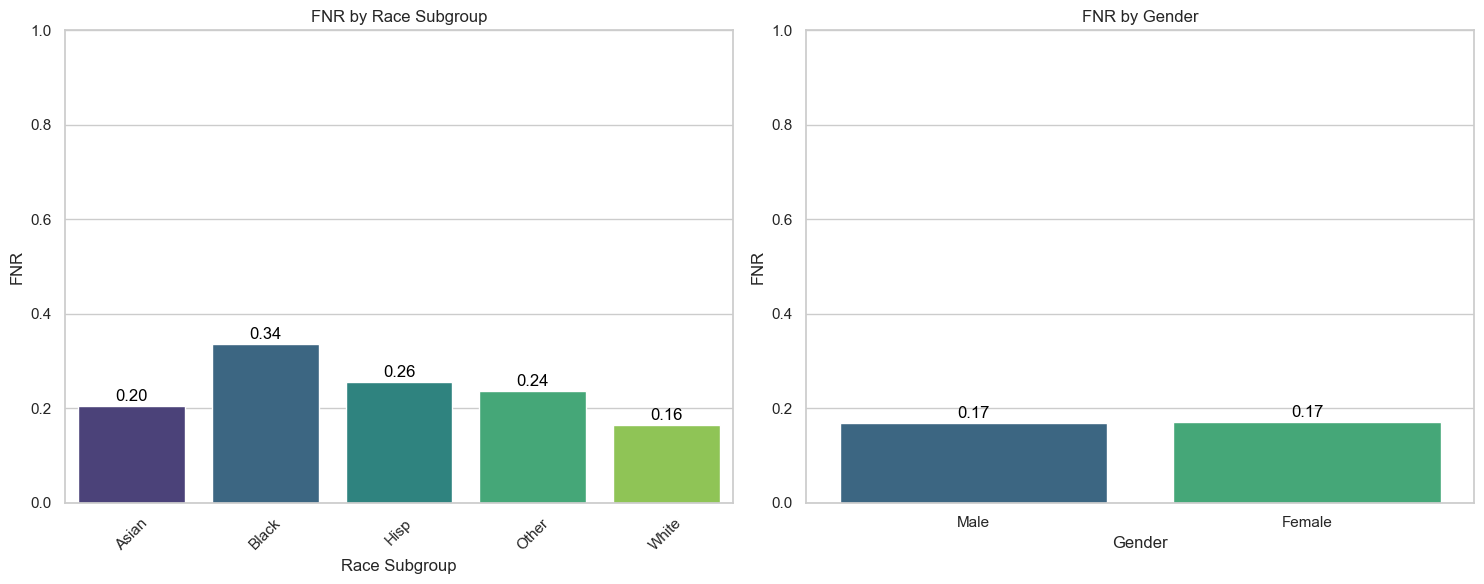

In [209]:


# Filter rows for 'race1' and 'gender'
race_results = results[results['Attribute'] == 'race1']
gender_results = results[results['Attribute'] == 'gender']

# Extract subgroups and FNR scores
race_subgroups = race_results['Group'].tolist()
race_accuracy_scores = race_results['FNR'].tolist()

gender_subgroups = gender_results['Group'].tolist()
gender_accuracy_scores = gender_results['FNR'].tolist()

# Create DataFrames for plotting
race_accuracy_df = pd.DataFrame({'Race Subgroup': race_subgroups, 'FNR': race_accuracy_scores})
gender_accuracy_df = pd.DataFrame({'Gender Subgroup': gender_subgroups, 'FNR': gender_accuracy_scores})

# Set plot style
sns.set(style="whitegrid")

# Create figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

# Plot for race accuracy scores
sns.barplot(x='Race Subgroup', y='FNR', data=race_accuracy_df, palette="viridis", ax=ax1)
ax1.set_title('FNR by Race Subgroup')
ax1.set_xlabel('Race Subgroup')
ax1.set_ylabel('FNR')
ax1.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Annotate race accuracy scores on bars
for index, row in race_accuracy_df.iterrows():
    ax1.text(index, row['FNR'] + 0.01, f'{row["FNR"]:.2f}', color='black', ha="center")

# Plot for gender accuracy scores
sns.barplot(x='Gender Subgroup', y='FNR', data=gender_accuracy_df, palette="viridis", ax=ax2)
ax2.set_title('FNR by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('FNR')
ax2.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax2.set_xticklabels(ax2.get_xticklabels())

# Annotate gender FNR scores on bars
for index, row in gender_accuracy_df.iterrows():
    ax2.text(index, row['FNR'] + 0.01, f'{row["FNR"]:.2f}', color='black', ha="center")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### Plotting accuracy score for each subgroup 

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/3152742009.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Race Subgroup', y='Accuracy', data=race_accuracy_df, palette="viridis", ax=ax1)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/3152742009.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/3152742009.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender Subgroup', y='Accuracy', data=gender_accuracy_df, palette="viridis", ax=ax2)
/

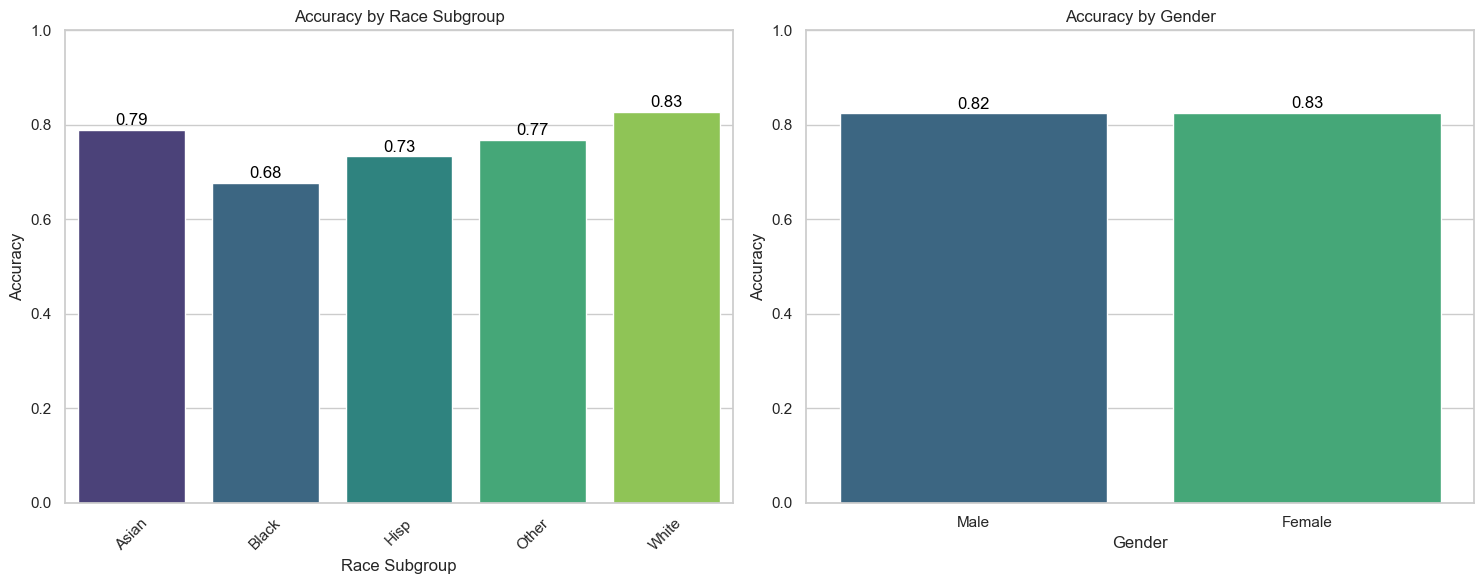

In [210]:

# Extract accuracy scores for each race subgroup
race_results = results[results['Attribute'] == 'race1']
race_subgroups = race_results['Group'].tolist()
race_accuracy_scores = race_results['Accuracy'].tolist()

# Extract accuracy scores for each gender subgroup
gender_results = results[results['Attribute'] == 'gender']
gender_subgroups = gender_results['Group'].tolist()
gender_accuracy_scores = gender_results['Accuracy'].tolist()

# Create a DataFrame for plotting race accuracy
race_accuracy_df = pd.DataFrame({'Race Subgroup': race_subgroups, 'Accuracy': race_accuracy_scores})

# Create a DataFrame for plotting gender accuracy
gender_accuracy_df = pd.DataFrame({'Gender Subgroup': gender_subgroups, 'Accuracy': gender_accuracy_scores})

# Set plot style
sns.set(style="whitegrid")

# Create figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

# Plot for race accuracy scores
sns.barplot(x='Race Subgroup', y='Accuracy', data=race_accuracy_df, palette="viridis", ax=ax1)
ax1.set_title('Accuracy by Race Subgroup')
ax1.set_xlabel('Race Subgroup')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Annotate race accuracy scores on bars
for index, row in race_accuracy_df.iterrows():
    ax1.text(index, row['Accuracy'] + 0.01, f'{row["Accuracy"]:.2f}', color='black', ha="center")

# Plot for gender accuracy scores
sns.barplot(x='Gender Subgroup', y='Accuracy', data=gender_accuracy_df, palette="viridis", ax=ax2)
ax2.set_title('Accuracy by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax2.set_xticklabels(ax2.get_xticklabels())

# Annotate gender accuracy scores on bars
for index, row in gender_accuracy_df.iterrows():
    ax2.text(index, row['Accuracy'] + 0.01, f'{row["Accuracy"]:.2f}', color='black', ha="center")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Now that we have the baseline evaluations, let's move on to implementing fair PCA and standard PCA

# Fair PCA implementation

First we load in the data

In [211]:

def preprocess_and_split_data(df):
    # Define features and target
    features = df.drop('pass_bar', axis=1)  # Drop the target column to get features
    target = df['pass_bar']

    # Define groups (race and gender)
    groups = df[['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'gender']]

    # Drop unnecessary columns from features
    features = features.drop(['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'gender'], axis=1)

    # Preserve indices before splitting
    indices = features.index

    # Split data into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features, target, groups, test_size=0.2, random_state=0, shuffle=True
    )

    # Preserve indices in the split data
    X_train_index = X_train.index
    X_test_index = X_test.index

    return X_train, X_test, y_train, y_test, group_train, group_test, X_train_index, X_test_index

# Load the data
df = pd.read_csv('data/non_scaled_data.csv')

# Preprocess and split data
X_train, X_test, y_train, y_test, group_train, group_test, X_train_index, X_test_index = preprocess_and_split_data(df)


# Printing the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("group_train shape:", group_train.shape)
print("group_test shape:", group_test.shape)


X_train shape: (17925, 10)
X_test shape: (4482, 10)
y_train shape: (17925,)
y_test shape: (4482,)
group_train shape: (17925, 6)
group_test shape: (4482, 6)


## stanfard PCA + fair PCA implementation

In [212]:


def PCA(X_train, n_components):
    """ Implements sci-kit's version of basic PCA and returns sorted eigenvectors"""
    
    pca = SklearnPCA(n_components=n_components)
    X_PCA = pca.fit_transform(X_train)
    
    # Get the sorted eigenvalues and eigenvectors
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    # Sort eigenvectors based on eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Reverse order to get descending
    sorted_eig_vectors = eigenvectors[sorted_indices]
    
    return X_PCA, sorted_eig_vectors



def fair_PCA(X_train, groups):

    """Implements fair PCA"""

    #z = groups.astype(int)
    X = X_train
    Z = groups.astype(int)
 
    # Compute null space
    R = null_space(np.dot(Z.T, X))

    RTXXR = R.T @ X.T @ X @ R

    # Get eigenvalues and vectors
    eig_vals, eig_vectors = np.linalg.eig(RTXXR)

    # Sort to find the largest eigenvectors
    idxs = np.argsort(eig_vals)[::-1]
    sorted_eig_vectors = eig_vectors[:, idxs]
    top_k_eig_vectors = sorted_eig_vectors[:, :5]

    # Build matrix A which has the eigenvectors as columns
    A = top_k_eig_vectors
    
    # Multiply A with the null space
    U = R @ A

    # Return the reprocejted data
    X_fair_PCA = X_train @ U

    
    return X_fair_PCA, U

#### Correlation matrices

In [213]:

def corr_plot(X_train, groups, n_components=4, fair=True):
    """Plots the correlation between PCA components and protected features"""
    
    protected_features = groups 
    fig, axes = plt.subplots(figsize=(25, 5))

    if fair:
        # Get the fairPCA transformed data
        X_PCA_n, U = fair_PCA(X_train, groups)
    else:
        # Get the PCA transformed data
        X_PCA_n, sorted_eigen = PCA(X_train, n_components)

    protected_features = protected_features.astype(int)


    # Compute correlation between PCA components and protected features
    corr_matrix = np.corrcoef(np.column_stack((protected_features, X_PCA_n)).T)

    # Display only the correlation between PCA components and protected features
    corr_matrix = np.nan_to_num(corr_matrix[:protected_features.shape[1], protected_features.shape[1]:], nan=0.0)

    # Determine the range for x-axis labels based on the length of corr_matrix
    x_labels_range = range(1, corr_matrix.shape[1] + 1)

    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-.1, vmax=.1, square=True, ax=axes, fmt=".2f")
    if fair:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between Fair PCA and Prot. features")
    else:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between PCA and Prot. features")

    axes.set_yticklabels(['Asian', 'Black', 'Hispanic', 'Other', 'White','Gender'], va='center')
    axes.set_xlabel("Component")
    axes.set_ylabel("Protected Feature (Subgroup)")

    plt.tight_layout()
    plt.show()


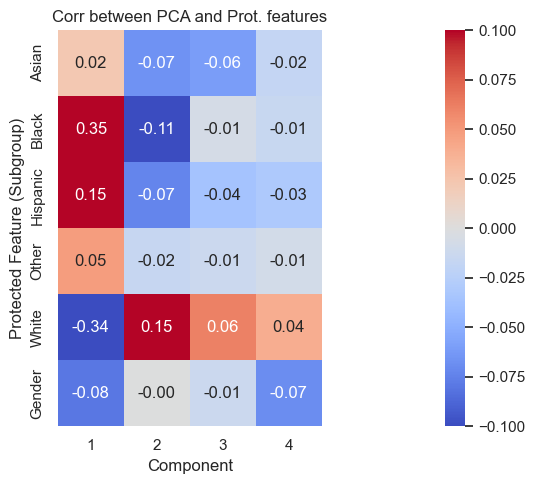

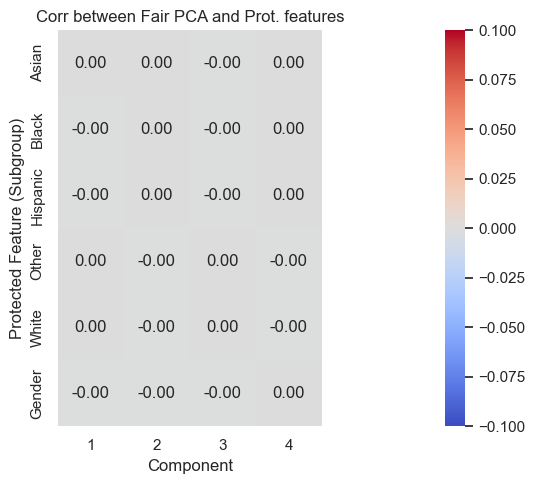

In [214]:
corr_plot(X_train, group_train, fair=False)
corr_plot(X_train, group_train, fair=True)

## Random Forest using fairPCA transformed data and standard PCA transformed data

Importing non scaled data which will be used for finding the indeces of each gender/race group

In [215]:


# Getting debiased data using PCA
X_train_fair_PCA, U = fair_PCA(X_train, group_train)
X_test_fair_PCA = X_test @ U

# Convert back to DataFrame and preserve indices
X_train_fair_PCA = pd.DataFrame(X_train_fair_PCA, index=X_train_index)
X_test_fair_PCA = pd.DataFrame(X_test_fair_PCA, index=X_test_index)

# Save X_train_PCA and X_test_PCA to CSV
X_train_fair_PCA.to_csv('data/X_train_fair_PCA.csv', index=True)
X_test_fair_PCA.to_csv('data/X_test_fair_PCA.csv', index=True)


# Save merged df to csv to use in shap analysis in other notebook to preserve the indices
merged_X_train = pd.merge(X_train, group_train, left_index=True, right_index=True)
merged_X_test = pd.merge(X_test, group_test, left_index=True, right_index=True)


merged_X_train.to_csv('data/X_train.csv', index=True)
merged_X_test.to_csv('data/X_test.csv', index=True)
y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')

In [216]:

# Random Forest model on debiased data
rf_fair_pca = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=25, random_state=42, class_weight='balanced')
rf_fair_pca.fit(X_train_fair_PCA, y_train)
y_pred_fair_pca_rf = rf_fair_pca.predict(X_test_fair_PCA)

# Calculate accuracy and F1 score
accuracy_fair_pca_rf = accuracy_score(y_test, y_pred_fair_pca_rf)
f1_fair_pca_rf = f1_score(y_test, y_pred_fair_pca_rf)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fair_pca_rf).ravel()

# Calculate the false negative rate (FNR)
fnr_fair_pca_rf = fn / (fn + tp)

# Print results
print(f"Accuracy (Random Forest on debiased data): {accuracy_fair_pca_rf}")
print(f"F1 Score (Random Forest on debiased data): {f1_fair_pca_rf}")
print(f"False Negative Rate (Random Forest on debiased data): {fnr_fair_pca_rf}")




Accuracy (Random Forest on debiased data): 0.7896028558679161
F1 Score (Random Forest on debiased data): 0.8791490452390106
False Negative Rate (Random Forest on debiased data): 0.19103773584905662


### Evaluating fair pca on each subgroup 

In [217]:

def evaluate_race_performance(model, X_test, y_test, group_test_non_scaled, column, flag):

    # Extract the column as a numpy array
    values = group_test_non_scaled[column].values

    if column == 'gender' and flag == 'Male':
        # Find male indeces
        X_test = X_test[values == 1]
        y_test = y_test[values == 1]

    elif column == 'gender' and flag == 'Female':
        # Find female indeces
        X_test = X_test[values == 0]
        y_test = y_test[values == 0]
    
    else:
        # find specific race indeces
        X_test = X_test[values == 1]
        y_test = y_test[values == 1]
        
    # Predict labels for the specific race/gender
    y_pred = model.predict(X_test)
    
    # Calculate accuracy for the specific race/hgender
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate the confusion matrix for the specific race/gender
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate the false negative rate (FNR) for the specific race/gender
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # Handle division by zero
    
    return accuracy, fnr

# List of columns to evaluate
columns = ['race1_asian', 'race1_black', 'race1_hisp', 'race1_white','race1_other', 'gender', 'gender']

# Initialize an empty list to store results
results = []


flag = 'Male'
for column in columns:
    accuracy, fnr = evaluate_race_performance(
        rf_fair_pca, 
        X_test_fair_PCA, 
        y_test, 
        group_test, 
        column,
        flag
    )



    # Print the results
    if column == 'gender':
        # Append the results to the list
        results.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': flag
        })

        print(f"Accuracy for {column, flag}: {accuracy:.4f}")
        print(f"False Negative Rate for {column, flag}: {fnr:.4f}")
        print()
        flag = 'Female'

    else:
        # Append the results to the list
        results.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': 'NA'
        })

        print(f"Accuracy for {column}: {accuracy:.4f}")
        print(f"False Negative Rate for {column}: {fnr:.4f}")
        print()

Accuracy for race1_asian: 0.7198
False Negative Rate for race1_asian: 0.2455

Accuracy for race1_black: 0.6549
False Negative Rate for race1_black: 0.2474

Accuracy for race1_hisp: 0.7273
False Negative Rate for race1_hisp: 0.2035

Accuracy for race1_white: 0.8069
False Negative Rate for race1_white: 0.1843

Accuracy for race1_other: 0.7083
False Negative Rate for race1_other: 0.2344

Accuracy for ('gender', 'Male'): 0.7887
False Negative Rate for ('gender', 'Male'): 0.1929

Accuracy for ('gender', 'Female'): 0.7908
False Negative Rate for ('gender', 'Female'): 0.1886



### Evaluating standard pca on each subgroup 

In [218]:
from sklearn.decomposition import PCA

def train_random_forest_with_pca(X_train, y_train, X_test, y_test, n_components=10, n_estimators=100, max_depth=10, min_samples_leaf=25, class_weight='balanced'):
    # PCA Transformation
    pca = PCA(n_components=n_components)
    X_PCA_train = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)
    
    # Random Forest model on PCA data
    rf_pca = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight=class_weight
    )
    rf_pca.fit(X_PCA_train, y_train)
    y_pred_pca_rf = rf_pca.predict(X_test_PCA)
    
    # Calculate accuracy and F1 score
    accuracy_pca_rf = accuracy_score(y_test, y_pred_pca_rf)
    f1_pca_rf = f1_score(y_test, y_pred_pca_rf)
    
    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_pca_rf).ravel()
    
    # Calculate the false negative rate (FNR)
    fnr_pca_rf = fn / (fn + tp) if (fn + tp) > 0 else float('nan')  # Avoid division by zero
    
    # Print results
    print(f"Accuracy (Random Forest on PCA data): {accuracy_pca_rf:.4f}")
    print(f"F1 Score (Random Forest on PCA data): {f1_pca_rf:.4f}")
    print(f"False Negative Rate (Random Forest on PCA data): {fnr_pca_rf:.4f}")
    print()
    
    # Return the model and PCA-transformed test data
    return rf_pca, X_test_PCA



rf_model_pca, X_test_PCA_transformed = train_random_forest_with_pca(
    X_train, y_train, X_test, y_test, 
    n_components=10, 
    n_estimators=100, 
    max_depth=10, 
    min_samples_leaf=25, 
    class_weight='balanced'
)

 

# List of columns to evaluate
columns = ['race1_asian', 'race1_black', 'race1_hisp', 'race1_white','race1_other', 'gender', 'gender']

# Initialize an empty list to store results
results_pca = []


flag = 'Male'
for column in columns:
    accuracy, fnr = evaluate_race_performance(
        rf_model_pca, 
        X_test_PCA_transformed, 
        y_test, 
        group_test, 
        column,
        flag
    )


    # Print the results
    if column == 'gender':
        # Append the results to the list
        results_pca.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': flag 
        })


        print(f"Accuracy for {column, flag}: {accuracy:.4f}")
        print(f"False Negative Rate for {column, flag}: {fnr:.4f}")
        print()
        flag = 'Female'


    else:

        # Append the results to the list
        results_pca.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': 'NA'
        })

        print(f"Accuracy for {column}: {accuracy:.4f}")
        print(f"False Negative Rate for {column}: {fnr:.4f}")
        print()

Accuracy (Random Forest on PCA data): 0.8541
F1 Score (Random Forest on PCA data): 0.9181
False Negative Rate (Random Forest on PCA data): 0.1354

Accuracy for race1_asian: 0.7802
False Negative Rate for race1_asian: 0.2156

Accuracy for race1_black: 0.4980
False Negative Rate for race1_black: 0.6474

Accuracy for race1_hisp: 0.6869
False Negative Rate for race1_hisp: 0.3081

Accuracy for race1_white: 0.8914
False Negative Rate for race1_white: 0.0960

Accuracy for race1_other: 0.8056
False Negative Rate for race1_other: 0.1875

Accuracy for ('gender', 'Male'): 0.8524
False Negative Rate for ('gender', 'Male'): 0.1375

Accuracy for ('gender', 'Female'): 0.8563
False Negative Rate for ('gender', 'Female'): 0.1326



### Comparison of FNR and accuracy score for baseline model and FairPCA model for the race attribute 

In [219]:
# Reading in the baseline results which are computed in the "baseline_evaluations.ipynb" notebook
baselines_results = pd.read_csv('data/results_baseline.csv')
results_baseline_df = baselines_results[baselines_results['Attribute'] != 'gender']


# Convert results to DataFrames
results_df = pd.DataFrame(results)
results_pca_df = pd.DataFrame(results_pca)


# Map race columns to readable names
race1_map = {
    'race1_asian': 'Asian',
    'race1_black': 'Black',
    'race1_hisp': 'Hisp',
    'race1_other': 'Other',
    'race1_white': 'White'
}

# Add a new column with readable race names if necessary
if 'Race Name' not in results_df.columns:
    results_df['Race Name'] = results_df['Column'].map(race1_map)
    results_pca_df['Race Name'] = results_pca_df['Column'].map(race1_map)

results_df = results_df[results_df['Column'] != 'gender']


## Comparison plots of baselines, PCA, fair pca

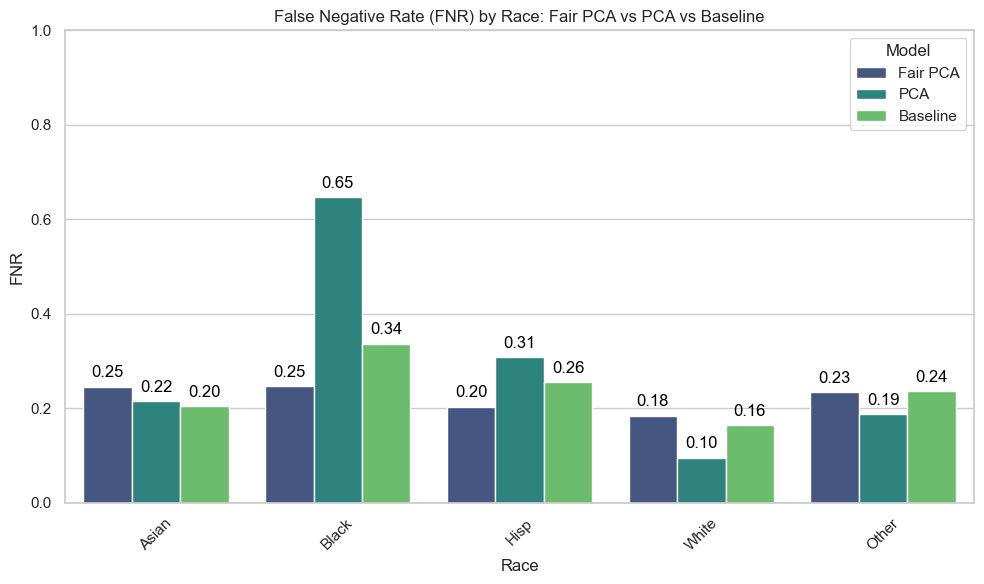

In [220]:


if 'Group' not in results_baseline_df.columns:
    results_baseline_df['Group'] = results_baseline_df['Attribute'].map(race1_map)

# Ensure the column names are consistent for merging
results_baseline_df = results_baseline_df.rename(columns={'Attribute': 'Race Column', 'Group': 'Race Name'})

# Add a new column to distinguish between the two datasets
results_df['Model'] = 'Fair PCA'
results_pca_df['Model'] = 'PCA'
results_baseline_df['Model'] = 'Baseline'

# Concatenate the two DataFrames
combined_df = pd.concat([results_df[['Column', 'FNR', 'Accuracy','Race Name', 'Model']],results_pca_df[['Column', 'FNR', 'Accuracy', 'Race Name', 'Model']],  results_baseline_df[['Race Column', 'FNR', 'Accuracy', 'Race Name', 'Model']]])

# Drop rows where 'Race Name' is NaN
combined_df = combined_df.dropna(subset=['Race Name'])

# Reset index to ensure unique index
combined_df = combined_df.reset_index(drop=True)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for FNR
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Race Name', y='FNR', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('False Negative Rate (FNR) by Race: Fair PCA vs PCA vs Baseline')
plt.xlabel('Race')
plt.ylabel('FNR')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate FNR scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Display the plot
plt.tight_layout()
plt.show()


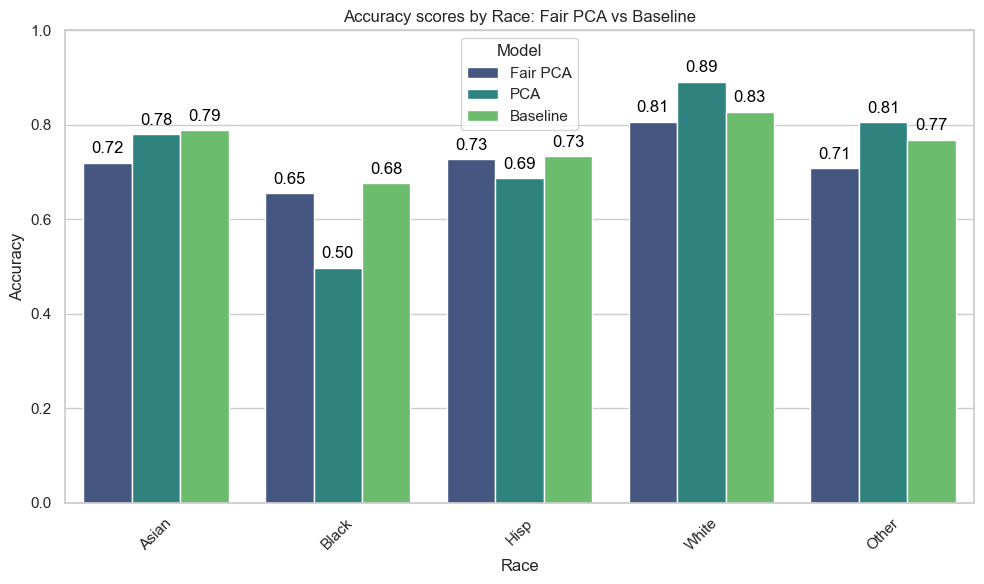

In [221]:

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for Accuracy
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Race Name', y='Accuracy', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('Accuracy scores by Race: Fair PCA vs Baseline')
plt.xlabel('Race')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate Accuracy scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Display the plot
plt.tight_layout()
plt.show()


### Evaluations for gender

##### preprocessing

In [222]:
# Reading in the baseline results which are computed in the "baseline_evaluations.ipynb" notebook
baselines_results = pd.read_csv('data/results_baseline.csv')
results_baseline_df = baselines_results[baselines_results['Attribute'] == 'gender']


# Convert results to DataFrames
results_df = pd.DataFrame(results)
results_pca_df = pd.DataFrame(results_pca)


results_df = results_df[results_df['Column'] == 'gender']
results_pca_df = results_pca_df[results_pca_df['Column'] == 'gender']


##### Plot for FNR among the gender group

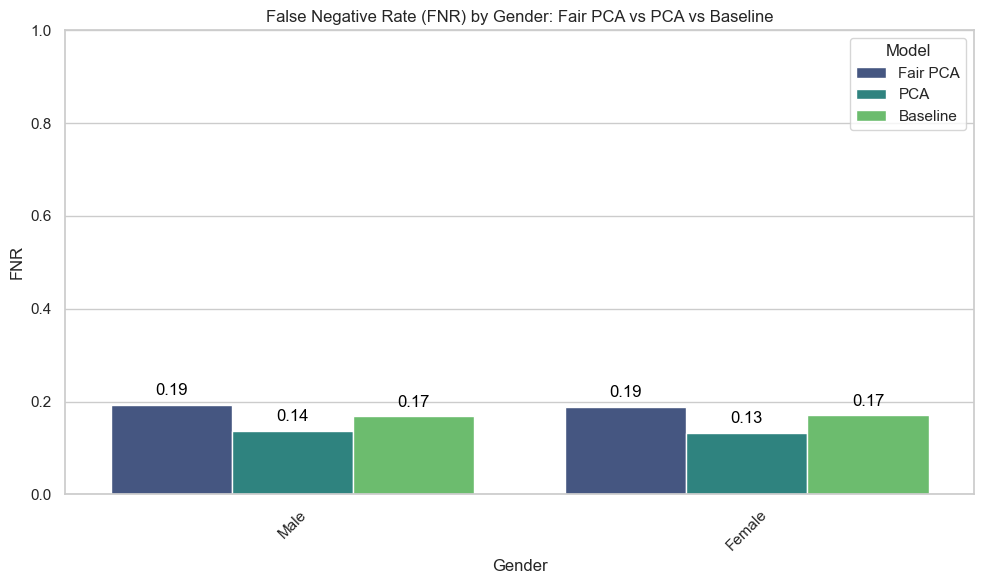

In [223]:


# Ensure the column names are consistent for merging 
results_baseline_df = results_baseline_df.rename(columns={'Group': 'Gender', 'Attribute': 'Column'})

# Add a new column to distinguish between the two datasets
results_df['Model'] = 'Fair PCA'
results_pca_df['Model'] = 'PCA'
results_baseline_df['Model'] = 'Baseline'

# Concatenate the two DataFrames
combined_df = pd.concat([results_df[['Column', 'FNR', 'Accuracy','Gender', 'Model']],results_pca_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']],  results_baseline_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']]])

# Reset index to ensure unique index
combined_df = combined_df.reset_index(drop=True)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for FNR
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Gender', y='FNR', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('False Negative Rate (FNR) by Gender: Fair PCA vs PCA vs Baseline')
plt.xlabel('Gender')
plt.ylabel('FNR')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate FNR scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Display the plot
plt.tight_layout()
plt.show()


##### Plot for accuracy among the gender group

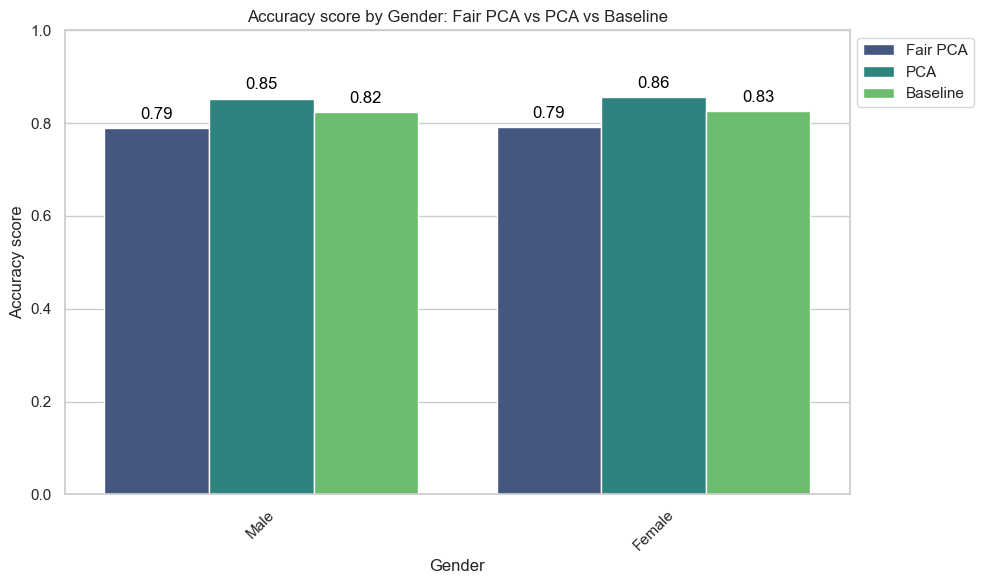

In [224]:


# Ensure the column names are consistent for merging 
results_baseline_df = results_baseline_df.rename(columns={'Group': 'Gender', 'Attribute': 'Column'})

# Add a new column to distinguish between the two datasets
results_df['Model'] = 'Fair PCA'
results_pca_df['Model'] = 'PCA'
results_baseline_df['Model'] = 'Baseline'

# Concatenate the two DataFrames
combined_df = pd.concat([results_df[['Column', 'FNR', 'Accuracy','Gender', 'Model']],results_pca_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']],  results_baseline_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']]])

# Reset index to ensure unique index
combined_df = combined_df.reset_index(drop=True)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for FNR
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Gender', y='Accuracy', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('Accuracy score by Gender: Fair PCA vs PCA vs Baseline')
plt.xlabel('Gender')
plt.ylabel('Accuracy score')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate Accuracy scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Move legende because it was overlapping with the bars
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.tight_layout()
plt.show()


# SHAP analysis

In [225]:

# Load the Fair PCA-transformed data
X_train = pd.read_csv('data/X_train.csv', index_col=0)
X_test = pd.read_csv('data/X_test.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0).iloc[:, 0]
y_test = pd.read_csv('data/y_test.csv', index_col=0).iloc[:, 0]


In [226]:

# Train a random forest model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values[:,:,1], max_display =16)


In [ ]:
# Read in fair data
fair_PCA_train = pd.read_csv('data/X_train_fair_PCA.csv', index_col=0)
fair_PCA_test = pd.read_csv('data/X_test_fair_PCA.csv', index_col=0)


### Finding data points which are ambigious in the model

In [ ]:

# Ensure gender filtering uses the original non-scaled data
indexes_with_gender_1 = X_test[X_test['gender'] == 1].index

# Filter the non scaled test data using the indices
X_test_filtered = X_test.loc[indexes_with_gender_1]

# Predict probabilities for the filtered data
probabilities = model.predict_proba(X_test_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff = np.abs(probabilities[:, 0] - probabilities[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_data_with_probs = pd.DataFrame(
    np.column_stack((X_test_filtered.values, probabilities, prob_diff)),
    columns=X_test_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=X_test_filtered.index  # Preserve original indices
)


# Load the gold labels for the test set
gold_labels = pd.read_csv('data/y_test.csv', index_col=0)

# Merge the gold labels with the filtered  DataFrame
filtered_with_probs = filtered_data_with_probs.join(gold_labels)


# Sort the data by the absolute difference between the class probabilities
sorted_filtered_data = filtered_with_probs.sort_values(by='prob_diff')

# Output the top 10 data points where the probabilities are most balanced
top_10_balanced = sorted_filtered_data.head(10)

# Display the probabilities for the top 10 balanced data points
for index, row in top_10_balanced.iterrows():
    print(f"Index: {index}, Gold Label: {row['pass_bar']}, "
          f"Probabilities: Class 0 = {row['prob_class_0']:.4f}, "
          f"Class 1 = {row['prob_class_1']:.4f}, "
          f"Difference = {row['prob_diff']:.4f}")



Index: 19184, Gold Label: 0.0, Probabilities: Class 0 = 0.5000, Class 1 = 0.5000, Difference = 0.0000
Index: 21666, Gold Label: 1.0, Probabilities: Class 0 = 0.5100, Class 1 = 0.4900, Difference = 0.0200
Index: 11417, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 12117, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 21476, Gold Label: 1.0, Probabilities: Class 0 = 0.5200, Class 1 = 0.4800, Difference = 0.0400
Index: 19990, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 21930, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 6204, Gold Label: 1.0, Probabilities: Class 0 = 0.4700, Class 1 = 0.5300, Difference = 0.0600
Index: 12277, Gold Label: 1.0, Probabilities: Class 0 = 0.4700, Class 1 = 0.5300, Difference = 0.0600
Index: 16170, Gold Label: 0.0, Probabilities: Class 0 = 0.4700, Class 1 = 0.5300, D

### Evaluating the previsouly ambigious datapoints using the FairPCA transformed data

In [ ]:
# Get the indices of the top 10 balanced data points
indices_of_interest = top_10_balanced.index

# Filter the Fair PCA test data
fair_PCA_filtered = fair_PCA_test.loc[indices_of_interest]


In [ ]:

# Train a random forest model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(fair_PCA_train, y_train)

# Evaluate on the test set using fair dataset
y_pred = model.predict(fair_PCA_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



# Predict probabilities on the filtered Fair PCA test data
probabilities_fair_pca = model.predict_proba(fair_PCA_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff_fair_pca = np.abs(probabilities_fair_pca[:, 0] - probabilities_fair_pca[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_fair_pca_with_probs = pd.DataFrame(
    np.column_stack((fair_PCA_filtered, probabilities_fair_pca, prob_diff_fair_pca)),
    columns=fair_PCA_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=indices_of_interest  # Use the original indices for easy reference
)

# Load the gold labels for the test set
gold_labels = pd.read_csv('data/y_test.csv', index_col=0)

# Merge the gold labels with the filtered Fair PCA DataFrame
filtered_fair_pca_with_probs = filtered_fair_pca_with_probs.join(gold_labels)

# Sort the data by the absolute difference between the class probabilities
sorted_fair_pca = filtered_fair_pca_with_probs.sort_values(by='prob_diff')

# Extract the top 10 data points where the probabilities are most balanced
top_10_balanced_fair_pca = sorted_fair_pca.head(10)

# Display the probabilities and gold labels for the top 10 balanced data points
for index, row in top_10_balanced_fair_pca.iterrows():
    print(f"Index: {index}, Gold Label: {row['pass_bar']}, "
          f"Probabilities: Class 0 = {row['prob_class_0']:.4f}, "
          f"Class 1 = {row['prob_class_1']:.4f}, "
          f"Difference = {row['prob_diff']:.4f}")



Accuracy: 0.9462293618920125
Index: 16170, Gold Label: 0.0, Probabilities: Class 0 = 0.5200, Class 1 = 0.4800, Difference = 0.0400
Index: 12117, Gold Label: 1.0, Probabilities: Class 0 = 0.2700, Class 1 = 0.7300, Difference = 0.4600
Index: 21930, Gold Label: 1.0, Probabilities: Class 0 = 0.2700, Class 1 = 0.7300, Difference = 0.4600
Index: 19990, Gold Label: 1.0, Probabilities: Class 0 = 0.2400, Class 1 = 0.7600, Difference = 0.5200
Index: 21476, Gold Label: 1.0, Probabilities: Class 0 = 0.1600, Class 1 = 0.8400, Difference = 0.6800
Index: 21666, Gold Label: 1.0, Probabilities: Class 0 = 0.0800, Class 1 = 0.9200, Difference = 0.8400
Index: 11417, Gold Label: 1.0, Probabilities: Class 0 = 0.0800, Class 1 = 0.9200, Difference = 0.8400
Index: 12277, Gold Label: 1.0, Probabilities: Class 0 = 0.0800, Class 1 = 0.9200, Difference = 0.8400
Index: 6204, Gold Label: 1.0, Probabilities: Class 0 = 0.0600, Class 1 = 0.9400, Difference = 0.8800
Index: 19184, Gold Label: 0.0, Probabilities: Class 0 

In [ ]:
def compare_predictions(top_10_balanced, top_10_balanced_fair_pca):

    # Identify observations predicted as class 0 in the original and class 1 in the fair PCA based on probabilities
    changed_predictions = top_10_balanced[
        (top_10_balanced['prob_class_0'] >= top_10_balanced['prob_class_1']) & 
        (top_10_balanced_fair_pca['prob_class_0'] < top_10_balanced_fair_pca['prob_class_1'])
    ]
    
    return changed_predictions

compare_predictions(top_10_balanced, top_10_balanced_fair_pca)

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_13848/3484850795.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  changed_predictions = top_10_balanced[


,decile1b,decile3,decile1,lsat,ugpa,DOB_yr,fam_inc,tier,grad,fulltime,race1_asian,race1_black,race1_hisp,race1_other,race1_white,gender,prob_class_0,prob_class_1,prob_diff,pass_bar
19184,4.000000,1.000000,4.000000,21.5,3.0,64.0,2.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.50,0.50,0.00,0
21666,5.528481,5.525934,5.708234,27.0,2.5,32.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.51,0.49,0.02,1
21476,3.000000,3.000000,4.000000,25.5,2.5,66.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.52,0.48,0.04,1
